In [5]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#path = '/home/kian/Dropbox/NTPU/Course/2022Fall/Economic Forecast'
path = '/Users/liurenhao/Documents/TaipeiuniversityNote/EcnomicForcast/final/for_class_t/Treating and Pruning-20230103'
data = pd.read_excel(path+'/M3C.xls', sheet_name='M3Month')
y0 = data.loc[data['Series'] == 'N2056',:]
y0 = y0.iloc[0,6:].T.dropna()
y = pd.Series(np.array(y0),index=pd.period_range(start='1980-1-1',periods=len(y0) ,freq='M'),name='N2056').astype('float64')
from statsmodels.tsa.seasonal import STL
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sktime.forecasting.ets import AutoETS
from itertools import product
import warnings
T = len(y)
model = AutoETS(auto=True,seasonal='add',sp=12)

In [18]:
error = ['add','mul']
trend = ['add','mul']
seasonal = ['add','mul']
damped_trend = [True, False]
models = list(product(error,trend,seasonal,damped_trend))
model = [None]*len(models)
y_ciu = pd.DataFrame(np.zeros((T,len(models))),pd.period_range(start='1980-1-1',periods=len(y0) ,freq='M'))
yf = pd.DataFrame(np.zeros((T,len(models))),pd.period_range(start='1980-1-1',periods=len(y0) ,freq='M'))
bic = np.zeros(len(models))+9999
for ii,jj in enumerate(models):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            model[ii] = AutoETS(sp=12,error=jj[0],trend=jj[1],seasonal=jj[2],damped_trend=jj[3]).fit(y)
            yf.iloc[:,ii] = model[ii].predict(fh=pd.period_range(start='1980-1-1',periods=len(y0) ,freq='M'))
            y_ciu.iloc[:,ii] = model[ii].predict_interval(fh=pd.period_range(start='1980-1-1',periods=len(y0) ,freq='M')).iloc[:,1]
            bic[ii] = model[ii].get_fitted_params()['aicc']
        except ValueError:
            pass

In [7]:
model[ii].predict_interval(fh=pd.period_range(start='1980-1-1',periods=len(y0) ,freq='M')).iloc[:,1]

1980-01    5004.008390
1980-02    4533.920708
1980-03    4786.251677
1980-04    4433.756525
1980-05    4568.540105
              ...     
1991-08    7693.803289
1991-09    6702.464424
1991-10    6510.754489
1991-11    6508.164387
1991-12    7385.467899
Freq: M, Name: (Coverage, 0.9, upper), Length: 144, dtype: float64

<AxesSubplot:>

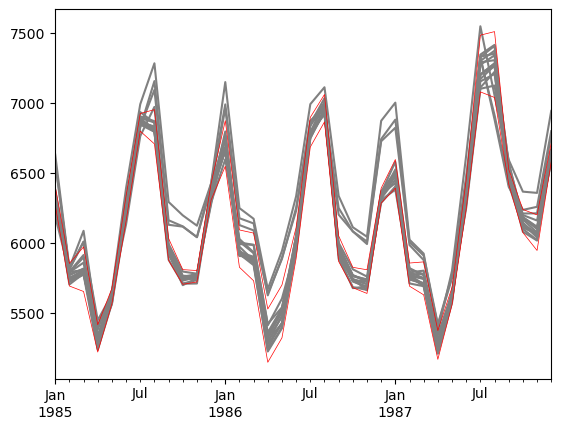

In [8]:
upCI = y_ciu.quantile(q=0.5, axis=1)+1.5*(y_ciu.quantile(q=0.75, axis=1)-y_ciu.quantile(q=0.25, axis=1))
lowerCI = y_ciu.quantile(q=0.5, axis=1)-1.5*(y_ciu.quantile(q=0.75, axis=1)-y_ciu.quantile(q=0.25, axis=1))
ax = y_ciu['1985':'1987'].plot(legend=False,color='gray')
pd.concat((upCI,lowerCI),axis=1)['1985':'1987'].plot(ax=ax,color='red',legend=False,lw=0.5)

In [9]:
sel_index = list(range(len(models)))
for ii in range(len(models)):
    if np.sum(y_ciu.iloc[:,ii]<lowerCI)>0 or np.sum(y_ciu.iloc[:,ii]>upCI)>0:
        sel_index.remove(ii)

In [10]:
best_model = model[sel_index[np.argmin(bic[sel_index])]]

In [11]:
weights = np.exp(-0.5*(bic[sel_index]-np.min(bic[sel_index])))/np.sum(np.exp(-0.5*(bic[sel_index]-np.min(bic[sel_index]))))

In [12]:
bic[sel_index]

array([1955.01417705, 1957.22901912, 1955.87336505, 1945.79368855])

In [13]:
sel_index

[3, 6, 7, 15]

In [14]:
y_ave = yf[sel_index]@weights

<AxesSubplot:>

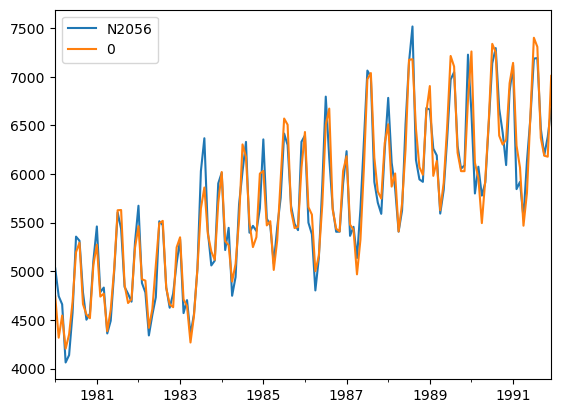

In [15]:
pd.concat((y,y_ave),axis=1).plot()

In [16]:
def seasonality_test(original_ts, ppy):
    """
    Seasonality test
    :param original_ts: time series
    :param ppy: periods per year
    :return: boolean value: whether the TS is seasonal
    """
    
    # Note that the statistical benchmarks, implemented in R, use the same seasonality test, but with ACF1 being squared
    # This difference between the two scripts was mentioned after the end of the competition and, therefore, no changes have been made 
    # to the existing code so that the results of the original submissions are reproducible
    s = acf(original_ts, 1)
    for i in range(2, ppy):
        s = s + (acf(original_ts, i) ** 2)

    limit = 1.645 * (np.sqrt((1 + 2 * s) / len(original_ts)))

    return (abs(acf(original_ts, ppy))) > limit


def acf(data, k):
    """
    Autocorrelation function
    :param data: time series
    :param k: lag
    :return:
    """
    m = np.mean(data)
    s1 = 0
    for i in range(k, len(data)):
        s1 = s1 + ((data[i] - m) * (data[i - k] - m))

    s2 = 0
    for i in range(0, len(data)):
        s2 = s2 + ((data[i] - m) ** 2)

    return float(s1 / s2)

In [17]:
seasonality_test(y, 365)

False